# The Effect of Transfer Learning on EfficientNet
---
[EfficientNet: Increasing the Accuracy and Robustness CNNs: EfficientNet]() implementation is prepared as an attachment to the blog post [CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html) Transfer Learning was performed on the CIFAR10 dataset.

---

### References: 

*   [EfficientNet: Rethinking Model Scaling for Convolutional Neural Networks](https://arxiv.org/pdf/1905.11946v3.pdf)

*   [Implementation of EfficientNet model. Keras and TensorFlow Keras](https://github.com/qubvel/efficientnet)
*   [Papers with Codes](https://paperswithcode.com/paper/efficientnet-rethinking-model-scaling-for)
*   [EfficientNet: Improving Accuracy and Efficiency through AutoML and Model Scaling](https://ai.googleblog.com/2019/05/efficientnet-improving-accuracy-and.html)
*   [How to do Transfer learning with Efficientnet](https://www.dlology.com/blog/transfer-learning-with-efficientnet/)
*   [Training EfficientNets on TPUs](https://github.com/tensorflow/tpu/tree/master/models/official/efficientnet)








**Google Colab Authentication**

In [3]:
# Mount drive 
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [4]:
path = "//content//gdrive//My Drive//AI School Class//"
import os
os.path.isdir(path)   

True

**Installing EfficientNet Source Model**

In [18]:
import warnings
warnings.filterwarnings("ignore")

!pip install -U git+https://github.com/qubvel/efficientnet

  Cloning https://github.com/qubvel/efficientnet to /tmp/pip-req-build-w7vw2i95
  Running command git clone -q https://github.com/qubvel/efficientnet /tmp/pip-req-build-w7vw2i95
  Created wheel for efficientnet: filename=efficientnet-1.1.1-cp36-none-any.whl size=18421 sha256=c7caf088c98bf0b4384d2d9389a51a951adde9ea9652c496cb6c2849264f04df
  Stored in directory: /tmp/pip-ephem-wheel-cache-_r8cttw5/wheels/64/60/2e/30ebaa76ed1626e86bfb0cc0579b737fdb7d9ff8cb9522663a
Successfully built efficientnet
  Found existing installation: efficientnet 1.1.1
    Uninstalling efficientnet-1.1.1:
      Successfully uninstalled efficientnet-1.1.1


**Importing necessary libraries** 

In [5]:
import keras
from keras.datasets import cifar10
from keras.models import Model
from keras.layers import Dense, Dropout, Activation, BatchNormalization, Flatten
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
import efficientnet.keras as enet

**Downloading CIFAR10 Dateset**

In [6]:
# CIFAR10

(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# Converting class vectors to binary class matrices
num_classes = 10
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


**Definition of Swish Activation Function**

---
ou can read more about Swish [here](https://towardsdatascience.com/comparison-of-activation-functions-for-deep-neural-networks-706ac4284c8a)!




In [7]:
from keras.backend import sigmoid

class SwishActivation(Activation):
    
    def __init__(self, activation, **kwargs):
        super(SwishActivation, self).__init__(activation, **kwargs)
        self.__name__ = 'swish_act'

def swish_act(x, beta = 1):
    return (x * sigmoid(beta * x))

from keras.utils.generic_utils import get_custom_objects
from keras.layers import Activation
get_custom_objects().update({'swish_act': SwishActivation(swish_act)})

**Model of EfficientNet-B0** (pre-trained with imagenet)

In [8]:
model = enet.EfficientNetB0(include_top=False, input_shape=(32,32,3), pooling='avg', weights='imagenet')

# Adding 2 fully-connected layers to B0.
x = model.output

x = BatchNormalization()(x)
x = Dropout(0.7)(x)

x = Dense(512)(x)
x = BatchNormalization()(x)
x = Activation(swish_act)(x)
x = Dropout(0.5)(x)

x = Dense(128)(x)
x = BatchNormalization()(x)
x = Activation(swish_act)(x)

# Output layer
predictions = Dense(10, activation="softmax")(x)
model_final = Model(inputs = model.input, outputs = predictions)

In [9]:
model_final.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, 16, 16, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, 16, 16, 32)   128         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, 16, 16, 32)   0           stem_bn[0][0]                    
_______________________________________________________________________________________

In [10]:
!pwd

/content


Train: X=(50000, 32, 32, 3), y=(50000, 10)
Test: X=(10000, 32, 32, 3), y=(10000, 10)


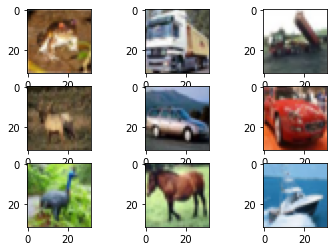

In [11]:
# summarize loaded dataset
print('Train: X=%s, y=%s' % (x_train.shape, y_train.shape))
print('Test: X=%s, y=%s' % (x_test.shape, y_test.shape))

from matplotlib import pyplot
# plot first few images
for i in range(9):
	# define subplot
	pyplot.subplot(330 + 1 + i)
	# plot raw pixel data
	pyplot.imshow(x_train[i])
# show the figure
pyplot.show()

In [12]:
model_path = path + "Transfer Learning Models//"
import os
os.path.isdir(model_path) 

True

**Compile the Model and Save the Best Results**

In [13]:
model_final.compile(loss='categorical_crossentropy',
              optimizer=Adam(0.0001),
              metrics=['accuracy'])

mcp_save = ModelCheckpoint(model_path + 'EnetB0_CIFAR10_TL.h5', save_best_only=True, monitor='val_accuracy')
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=2, verbose=1,)

#print("Training....")
model_final.fit(x_train, y_train,
              batch_size=32,
              epochs=10,
              validation_split=0.1,
              callbacks=[mcp_save, reduce_lr],
              shuffle=True,
              verbose=1)

Epoch 1/10
1407/1407 [==============================] - 52s 37ms/step - loss: 1.8624 - accuracy: 0.3389 - val_loss: 1.2030 - val_accuracy: 0.5934
Epoch 2/10
1407/1407 [==============================] - 50s 36ms/step - loss: 1.1875 - accuracy: 0.5923 - val_loss: 0.8538 - val_accuracy: 0.7074
Epoch 3/10
1407/1407 [==============================] - 50s 36ms/step - loss: 0.9551 - accuracy: 0.6778 - val_loss: 0.7111 - val_accuracy: 0.7632
Epoch 4/10
1407/1407 [==============================] - 50s 35ms/step - loss: 0.8259 - accuracy: 0.7232 - val_loss: 0.6423 - val_accuracy: 0.7812
Epoch 5/10
1407/1407 [==============================] - 50s 36ms/step - loss: 0.7252 - accuracy: 0.7565 - val_loss: 0.5916 - val_accuracy: 0.7966
Epoch 6/10
1407/1407 [==============================] - 50s 36ms/step - loss: 0.6507 - accuracy: 0.7826 - val_loss: 0.5600 - val_accuracy: 0.8044
Epoch 7/10
1407/1407 [==============================] - 51s 36ms/step - loss: 0.5855 - accuracy: 0.8015 - val_loss: 0.5296 -

In [14]:
_, acc = model_final.evaluate(x_test, y_test)

313/313 [==============================] - 4s 11ms/step - loss: 0.5208 - accuracy: 0.8248


**Printing the test accuracy**

In [15]:
print("Test Accuracy: {}%".format(acc*100))

Test Accuracy: 82.48000144958496%


**Visualization of Confusion Matrix**

In [16]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

test_pred = model_final.predict(x_test)

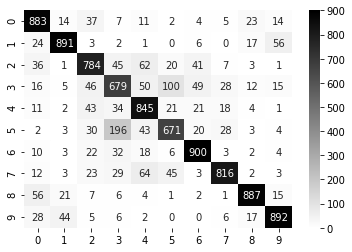

In [17]:
import numpy as np

ax = sns.heatmap(confusion_matrix(np.argmax(y_test, axis=1),np.argmax(test_pred, axis=1)), cmap="binary",annot=True,fmt="d")

In [19]:
from keras.models import load_model, model_from_json
model_load = load_model(path + 'Transfer Learning Models/EnetB0_CIFAR10_TL_backup.h5')

In [20]:
_, acc = model_load.evaluate(x_test, y_test)
print("Test Accuracy: {}%".format(acc*100))

313/313 [==============================] - 3s 11ms/step - loss: 0.5258 - accuracy: 0.8211
Test Accuracy: 82.10999965667725%


In [24]:
test_pred = model_load.predict(x_test)

In [25]:
test_pred

array([[3.4596276e-04, 1.5264638e-03, 1.4092099e-03, ..., 5.1225105e-04,
        4.9109414e-04, 1.0303841e-03],
       [1.4233998e-02, 2.7528590e-01, 4.7679852e-05, ..., 2.5452931e-05,
        7.0929247e-01, 1.0225910e-03],
       [8.3673019e-03, 2.0782763e-02, 9.9957571e-04, ..., 5.4456678e-04,
        9.5872337e-01, 4.9070455e-03],
       ...,
       [6.1052895e-05, 1.0507967e-04, 4.2534103e-03, ..., 4.9381377e-04,
        3.9538019e-05, 1.5808061e-04],
       [6.2532746e-03, 9.8816854e-01, 4.4134090e-04, ..., 1.9537896e-04,
        8.8237925e-04, 2.2581280e-03],
       [2.3700754e-04, 9.5143932e-04, 6.8632554e-04, ..., 9.7991896e-01,
        1.4383339e-04, 2.2788119e-04]], dtype=float32)

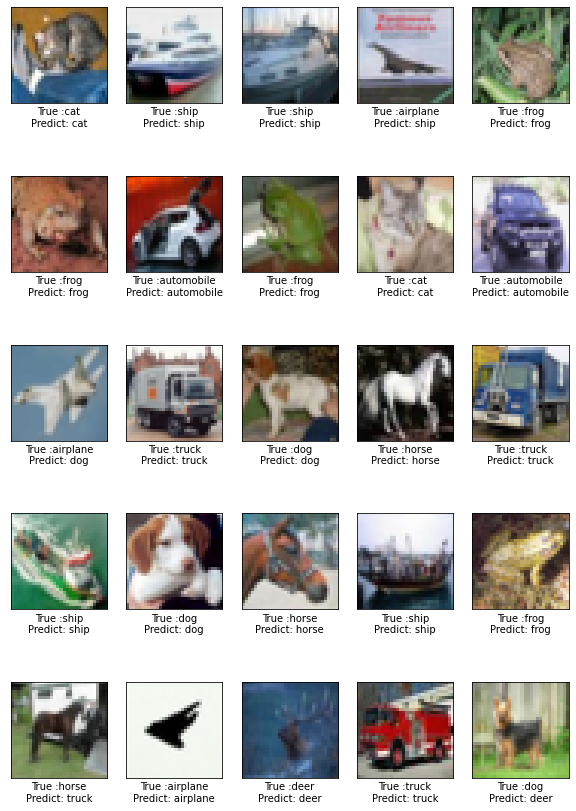

In [45]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(10,15))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_test[i], cmap=plt.cm.binary)
    # The CIFAR labels happen to be arrays, 
    # which is why you need the extra index
    result = 'True :' + class_names[list(y_test[i]).index(max(y_test[i]))]
    result = result + "\n" + "Predict: " + class_names[list(test_pred[i]).index(max(test_pred[i]))]
    plt.xlabel(result)
plt.show()